<a href="https://colab.research.google.com/github/Amelet/DeepLearning_TensorFLow/blob/main/03_introduction_to_computer_vision_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to convolutional neural networks and computer vision with tensorflow

data source is https://www.kaggle.com/datasets/dansbecker/food-101 (Kaggle, Food101). data was preprocessed by the course's author [ZTM](https://github.com/mrdbourke/tensorflow-deep-learning/tree/main).




In [ ]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

# unzip
zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

--2023-07-31 07:35:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.123.128, 142.250.98.128, 142.250.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.123.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M   156MB/s    in 0.7s    

2023-07-31 07:35:49 (156 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



We use a subset of Food101 dataset (only pizza and steak) to learn what works and what does not

In [ ]:
!ls pizza_steak/train/steak

1000205.jpg  1647351.jpg  2238681.jpg  2824680.jpg  3375959.jpg  417368.jpg
100135.jpg   1650002.jpg  2238802.jpg  2825100.jpg  3381560.jpg  4176.jpg
101312.jpg   165639.jpg   2254705.jpg  2826987.jpg  3382936.jpg  42125.jpg
1021458.jpg  1658186.jpg  225990.jpg   2832499.jpg  3386119.jpg  421476.jpg
1032846.jpg  1658443.jpg  2260231.jpg  2832960.jpg  3388717.jpg  421561.jpg
10380.jpg    165964.jpg   2268692.jpg  285045.jpg   3389138.jpg  438871.jpg
1049459.jpg  167069.jpg   2271133.jpg  285147.jpg   3393547.jpg  43924.jpg
1053665.jpg  1675632.jpg  227576.jpg   2855315.jpg  3393688.jpg  440188.jpg
1068516.jpg  1678108.jpg  2283057.jpg  2856066.jpg  3396589.jpg  442757.jpg
1068975.jpg  168006.jpg   2286639.jpg  2859933.jpg  339891.jpg	 443210.jpg
1081258.jpg  1682496.jpg  2287136.jpg  286219.jpg   3417789.jpg  444064.jpg
1090122.jpg  1684438.jpg  2291292.jpg  2862562.jpg  3425047.jpg  444709.jpg
1093966.jpg  168775.jpg   229323.jpg   2865730.jpg  3434983.jpg  447557.jpg
1098844.jpg  1697

In [ ]:
import os

# List number of files
print('The loaded folder has:')
for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print(f"\t{len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

The loaded folder has:
	2 directories and 0 images in 'pizza_steak'.
	2 directories and 0 images in 'pizza_steak/test'.
	0 directories and 250 images in 'pizza_steak/test/steak'.
	0 directories and 250 images in 'pizza_steak/test/pizza'.
	2 directories and 0 images in 'pizza_steak/train'.
	0 directories and 750 images in 'pizza_steak/train/steak'.
	0 directories and 750 images in 'pizza_steak/train/pizza'.


In [ ]:
# Another way (directly inspect one directory):
num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))
num_steak_images_train

750

In [ ]:
# create a list of label_names from teh subdirectories in a training folder
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train")
label_names = np.array(sorted(
    [item.name for item in data_dir.glob("*")]
))
label_names

array(['pizza', 'steak'], dtype='<U5')

In [ ]:
# Import necessary modules
import matplotlib.pyplot as plt     # Used for creating visualizations
import matplotlib.image as mpimg    # Used for handling image data
import random                       # Used for generating random numbers

# Define function to visualize random image from a target directory and label
def view_random_image(target_dir, target_label):
  # The target_folder is the path to the specific directory of images you're targeting.
  # This is found by joining the target directory (target_dir) and target label (target_label)
  target_folder = target_dir+target_label

  # Generate a random image file name from the target_folder directory
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image file and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])    # Reads the image file
  plt.imshow(img)    # Plots the image
  plt.title(target_label)    # Adds a title to the image plot (the title is the label of the image)
  plt.axis("off")    # Removes the axis from the image plot

  # Print the shape of the image
  print(f"Image shape: {img.shape}")

  # Return the image data
  return img

Image shape: (512, 382, 3)


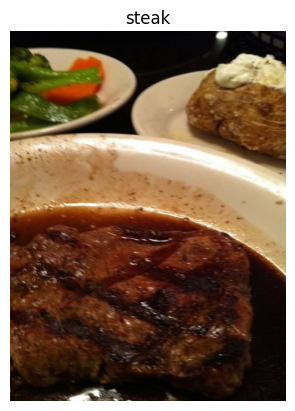

In [ ]:
img = view_random_image(target_dir="pizza_steak/train/",
                      target_label="steak")

In [ ]:
import tensorflow as tf
image_sample = tf.cast(tf.constant(img), tf.float32)
image_sample_norm = image_sample/255.0
image_sample.shape, np.max(image_sample_norm)

(TensorShape([512, 382, 3]), 1.0)

# Steps of end-to-end CNN
* load images
* preprocess them
* build CNN model
* compile it
* fit it to training dataset

In [ ]:
from keras.utils import image_dataset
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# seed
tf.random.set_seed(42)

# preprocess (scale/normalize)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# rescaling factor. Defaults to None. If None or 0, no rescaling is applied,
# otherwise we multiply the data by the value provided
# (after applying all other transformations).

# setup the path
train_dir = "/content/pizza_steak/train"
test_dir = "/content/pizza_steak/test"

train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size=(224,224), # we want top reshape, 224 is very common
                                               class_mode="binary",
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode="binary",
                                               seed=42)

# build a CNN model (the Tiny VGG from CNN explainer website)
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation="relu",
                           input_shape=(224,224,3)),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2,
                              padding="valid"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# compile
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# fit
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data), # this is number of batches (32 images per batch)
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 25s 164ms/step - loss: 0.5631 - accuracy: 0.7273 - val_loss: 0.4636 - val_accuracy: 0.7680
Epoch 2/5
47/47 [==============================] - 6s 135ms/step - loss: 0.4424 - accuracy: 0.8053 - val_loss: 0.3686 - val_accuracy: 0.8400
Epoch 3/5
47/47 [==============================] - 5s 115ms/step - loss: 0.4238 - accuracy: 0.8173 - val_loss: 0.4515 - val_accuracy: 0.7680
Epoch 4/5
47/47 [==============================] - 8s 160ms/step - loss: 0.3803 - accuracy: 0.8373 - val_loss: 0.3687 - val_accuracy: 0.8540
Epoch 5/5
47/47 [==============================] - 7s 140ms/step - loss: 0.2745 - accuracy: 0.9007 - val_loss: 0.3914 - val_accuracy: 0.8220


In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

# end to end development of CNN

Image shape: (512, 512, 3)
Image shape: (512, 512, 3)


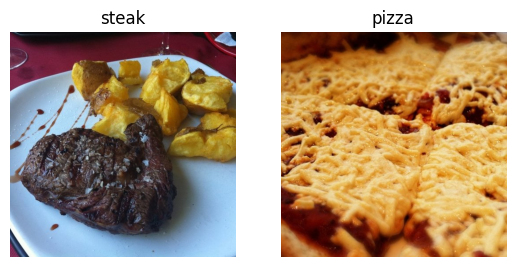

In [ ]:
# visualize
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image("pizza_steak/train/", "steak")
plt.subplot(1, 2, 2)
pizza_img = view_random_image("pizza_steak/train/", "pizza")
plt.show()

In [ ]:
# preprocess data
# setup the path
train_dir = "/content/pizza_steak/train"
test_dir = "/content/pizza_steak/test"

In [ ]:
# turn data into batches (subsets) to fit in memory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               batch_size=32)

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             class_mode="binary",
                                             batch_size=32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [ ]:
# get a sample of a train data batch
images, labels = train_data.next() # get teh next batch of img/lbl
len(images), len(labels), len(train_data)

(32, 32, 47)

In [ ]:
# get the data normalized for the first two images
images[0], images[0].shape

(array([[[0.41960788, 0.24705884, 0.07058824],
         [0.4156863 , 0.24313727, 0.06666667],
         [0.39607847, 0.22352943, 0.04705883],
         ...,
         [0.47450984, 0.28235295, 0.12156864],
         [0.48235297, 0.2901961 , 0.12941177],
         [0.48235297, 0.2901961 , 0.12941177]],
 
        [[0.3921569 , 0.21960786, 0.04313726],
         [0.4039216 , 0.23137257, 0.05490196],
         [0.427451  , 0.25490198, 0.07843138],
         ...,
         [0.46274513, 0.27058825, 0.10980393],
         [0.46274513, 0.27058825, 0.10980393],
         [0.4666667 , 0.27450982, 0.1137255 ]],
 
        [[0.4039216 , 0.23137257, 0.05490196],
         [0.39607847, 0.22352943, 0.04705883],
         [0.39607847, 0.22352943, 0.04705883],
         ...,
         [0.43921572, 0.24705884, 0.08627451],
         [0.45882356, 0.26666668, 0.10588236],
         [0.46274513, 0.27058825, 0.10980393]],
 
        ...,
 
        [[0.38823533, 0.34901962, 0.3137255 ],
         [0.40784317, 0.36862746, 0.33333

# CNN model (baseline)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [ ]:
# baseline model
model_bl = Sequential([
    Conv2D(filters=10,
           kernel_size=3,
           padding="valid",
           input_shape=(224, 224, 3), # input layer needs a shape
           activation="relu"),
    Conv2D(filters=10,
           kernel_size=3,
           padding="valid",
           activation="relu"),
    Conv2D(filters=10,
           kernel_size=3,
           padding="valid",
           activation="relu"),
    #MaxPool2D(pool_size=(2, 2)),
    Flatten(),
    Dense(1, activation="sigmoid")   # output layer for binary classification
])

model_bl.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_6 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten_1 (Flatten)         (None, 475240)            0         
                                                                 
 dense_1 (Dense)             (None, 1)                 475241    
                                                                 
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_bl.compile(loss="binary_crossentropy",
                 optimizer=Adam(),
                 metrics=["accuracy"])

history_bl = model_bl.fit(train_data,
                          epochs=5,
                          steps_per_epoch=len(train_data),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 9s 144ms/step - loss: 0.9705 - accuracy: 0.6380 - val_loss: 0.5747 - val_accuracy: 0.7460
Epoch 2/5
47/47 [==============================] - 6s 117ms/step - loss: 0.4604 - accuracy: 0.8040 - val_loss: 0.4207 - val_accuracy: 0.7980
Epoch 3/5
47/47 [==============================] - 6s 135ms/step - loss: 0.3565 - accuracy: 0.8573 - val_loss: 0.3844 - val_accuracy: 0.8300
Epoch 4/5
47/47 [==============================] - 6s 125ms/step - loss: 0.2204 - accuracy: 0.9253 - val_loss: 0.4285 - val_accuracy: 0.8080
Epoch 5/5
47/47 [==============================] - 6s 126ms/step - loss: 0.0983 - accuracy: 0.9727 - val_loss: 0.3973 - val_accuracy: 0.8260


<Axes: >

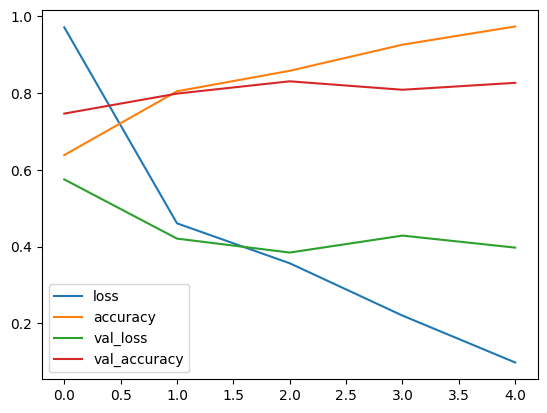

In [ ]:
import pandas as pd
hist_df = pd.DataFrame(history_bl.history)
hist_df.plot()

In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

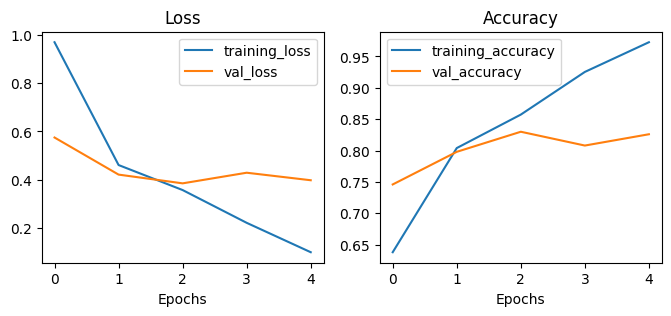

In [ ]:
# Check out the loss curves
fig = plt.figure(figsize=(8,3))
plot_loss_curves(history_bl)
plt.show()

# CNN baseline model 2

In [ ]:
model_bl2 = Sequential([
    Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(pool_size=2),
    Flatten(),
    Dense(1, activation="sigmoid")

])

In [ ]:
model_bl2.compile(loss="binary_crossentropy",
                 optimizer=Adam(),
                 metrics=["accuracy"])

history_bl2 = model_bl2.fit(train_data,
                          epochs=5,
                          steps_per_epoch=len(train_data),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 8s 139ms/step - loss: 0.5933 - accuracy: 0.6800 - val_loss: 0.4540 - val_accuracy: 0.8020
Epoch 2/5
47/47 [==============================] - 5s 114ms/step - loss: 0.4737 - accuracy: 0.7773 - val_loss: 0.3868 - val_accuracy: 0.8320
Epoch 3/5
47/47 [==============================] - 6s 128ms/step - loss: 0.4051 - accuracy: 0.8233 - val_loss: 0.3448 - val_accuracy: 0.8580
Epoch 4/5
47/47 [==============================] - 7s 144ms/step - loss: 0.3780 - accuracy: 0.8400 - val_loss: 0.3303 - val_accuracy: 0.8640
Epoch 5/5
47/47 [==============================] - 5s 109ms/step - loss: 0.3407 - accuracy: 0.8560 - val_loss: 0.3941 - val_accuracy: 0.8080


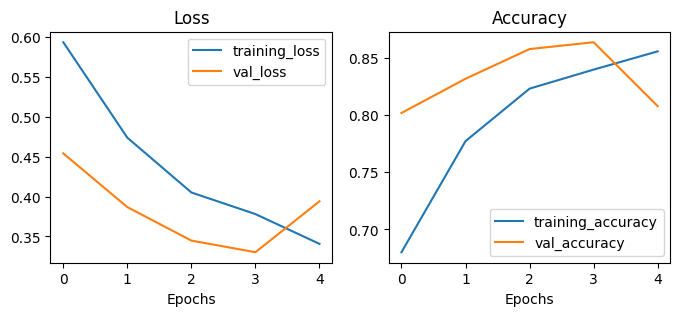

In [ ]:
# Check out the loss curves
fig = plt.figure(figsize=(8,3))
plot_loss_curves(history_bl2)
plt.show()

## CNN and Data augmentation

In [ ]:
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.3,
                                             shear_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.)

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

In [ ]:
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                     target_size=(224, 224),
                                                                     batch_size=32,
                                                                     class_mode="binary",
                                                                     shuffle=True) # This should be True

# Create non-augmented data batches
print("Non-augmented training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=True) # Don't shuffle for demonstration purposes

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')

Found 1500 images belonging to 2 classes.
Non-augmented training images:
Found 1500 images belonging to 2 classes.
Unchanged test images:
Found 500 images belonging to 2 classes.


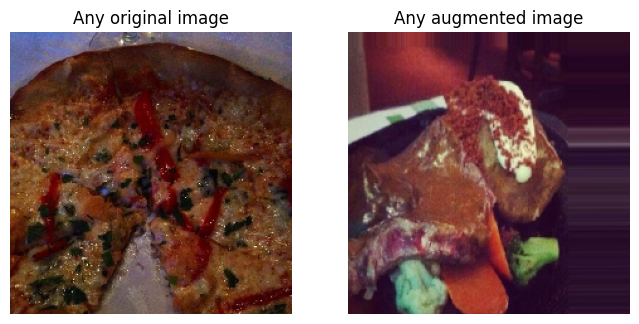

In [ ]:
# Get data batch samples
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() # Note: labels aren't augmented, they stay the same
# Show original image and augmented image
random_number = random.randint(0, 32) # we're making batches of size 32, so we'll get a random instance
fig = plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(images[random_number])
plt.title(f"Any original image")
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(augmented_images[random_number])
plt.title(f"Any augmented image")
plt.axis(False)
plt.show()

In [ ]:
model_1 = Sequential([
    Conv2D(10, 3, input_shape=(224, 224, 3), activation="relu"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

model_1.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

history_1 = model_1.fit(train_data_augmented,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data = test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 23s 455ms/step - loss: 0.6233 - accuracy: 0.6680 - val_loss: 0.4801 - val_accuracy: 0.8060
Epoch 2/5
47/47 [==============================] - 20s 436ms/step - loss: 0.5452 - accuracy: 0.7307 - val_loss: 0.4018 - val_accuracy: 0.8480
Epoch 3/5
47/47 [==============================] - 22s 461ms/step - loss: 0.5276 - accuracy: 0.7433 - val_loss: 0.3731 - val_accuracy: 0.8480
Epoch 4/5
47/47 [==============================] - 21s 456ms/step - loss: 0.4994 - accuracy: 0.7573 - val_loss: 0.3524 - val_accuracy: 0.8560
Epoch 5/5
47/47 [==============================] - 22s 463ms/step - loss: 0.4737 - accuracy: 0.7740 - val_loss: 0.3297 - val_accuracy: 0.8660


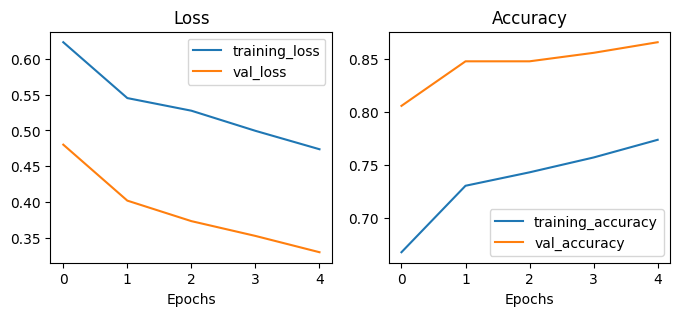

In [ ]:
# Check out the loss curves
fig = plt.figure(figsize=(8,3))
plot_loss_curves(history_1)
plt.show()

## Improve model's performance:
* increase # of layers
* increase number of filters 10, 32, 64
* take more epochs
* optimal leearning rate
* more data
* use transfer learning

# Predict using our model

--2023-07-31 07:41:03--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘03-pizza-dad.jpeg’

03-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.08s   

2023-07-31 07:41:03 (33.4 MB/s) - ‘03-pizza-dad.jpeg’ saved [2874848/2874848]

--2023-07-31 07:41:03--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting res

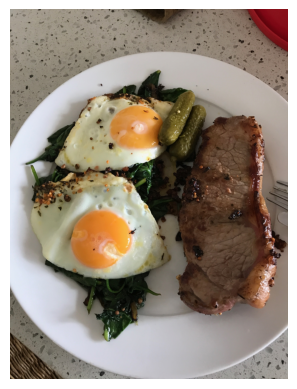

In [ ]:
# View our example image
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
# this url also works: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/images/03-steak.jpeg?raw=true
steak = mpimg.imread("03-steak.jpeg")
plt.imshow(steak)
plt.axis(False);


In [ ]:
print('Shape of the image: ', steak.shape)
# We need to expand dimentions to match the expected by the model shape
print('Expanded shape, add one dimention, which is the batch size')
expanded_steak = tf.expand_dims(steak, axis=0)
print('New shape of the image:', expanded_steak.shape)
# More to it, we need to match the size of the image itself

Shape of the image:  (4032, 3024, 3)
Expanded shape, add one dimention, which is the batch size
New shape of the image: (1, 4032, 3024, 3)


In [ ]:
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from teh file, turns it into a tensor and reshapes it
  to (img_shape, img_shape, colour_channels).
  """

  # Read
  img = tf.io.read_file(filename)

  # To tensor
  img = tf.image.decode_image(img)

  # Resize
  img = tf.image.resize(img, size=[img_shape, img_shape])

  # Rescale
  img = img/255.

  return img


# Adjust function to work with multi-class and binary
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
    print('Multiclass')
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round
    print('Binary')

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

1/1 [==============================] - 0s 226ms/step
Binary


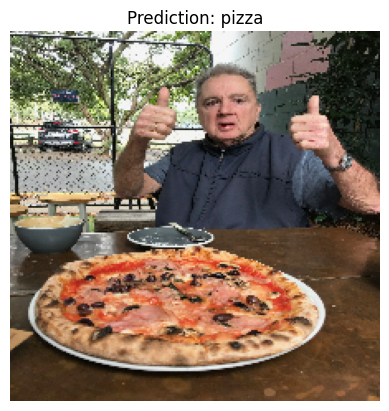

In [ ]:
filename = "03-steak.jpeg"
filename = "03-pizza-dad.jpeg"
img_prepared = load_and_prep_image(filename, img_shape=224)
pred_and_plot(model_1, filename, label_names)

# Multi-class Image Classification

* Become one with the data (visualize...)
* Preprocess the data (prepare it for a model)
* Create a model (start with a baseline)
* Fit the model
* Evaluate the model
* Adjust different parameters and improve model (try to beat your baseline)
* Repeat until satisfied

In [ ]:
import zipfile

# Download zip file of 10_food_classes images
# See how this data was created - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-07-31 07:41:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.196.128, 173.194.212.128, 173.194.213.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.196.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  46.5MB/s    in 6.4s    

2023-07-31 07:41:14 (77.5 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"""{dirpath}
        Directories: {len(dirnames)}
        Images: {len(filenames)}""")

10_food_classes_all_data
        Directories: 2
        Images: 0
10_food_classes_all_data/test
        Directories: 10
        Images: 0
10_food_classes_all_data/test/sushi
        Directories: 0
        Images: 250
10_food_classes_all_data/test/ice_cream
        Directories: 0
        Images: 250
10_food_classes_all_data/test/grilled_salmon
        Directories: 0
        Images: 250
10_food_classes_all_data/test/chicken_wings
        Directories: 0
        Images: 250
10_food_classes_all_data/test/chicken_curry
        Directories: 0
        Images: 250
10_food_classes_all_data/test/ramen
        Directories: 0
        Images: 250
10_food_classes_all_data/test/hamburger
        Directories: 0
        Images: 250
10_food_classes_all_data/test/fried_rice
        Directories: 0
        Images: 250
10_food_classes_all_data/test/steak
        Directories: 0
        Images: 250
10_food_classes_all_data/test/pizza
        Directories: 0
        Images: 250
10_food_classes_all_data/train
   

In [ ]:
# Setup directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

# Get classnames
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(
    sorted(
        [item.name for item in data_dir.glob('*')]
    )
)
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

Image shape: (512, 512, 3)


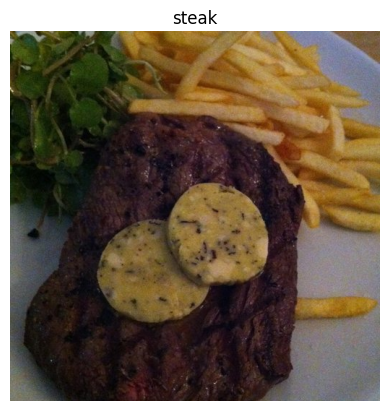

In [ ]:
import random
img = view_random_image(target_dir=train_dir,
                        target_label=random.choice(class_names))

In [ ]:
# data preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)
train_datagen_augmented = ImageDataGenerator(rotation_range=20,       # rotate the image 20 degrees
                                             width_shift_range=0.10,  # Shift the pic width by a max of 10%
                                             height_shift_range=0.10, # Shift the pic height by a max of 10%
                                             rescale=1./255,          # Rescale the image by normalzing it.
                                             shear_range=0.1,         # Shear means cutting away part of the image (max 10%)
                                             zoom_range=0.1,          # Zoom in by 10% max
                                             horizontal_flip=True)    # Allow horizontal flipping

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode="categorical")

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode="categorical")

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [ ]:
# build the model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

model_10cl = Sequential([
    Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation="softmax")
])

model_10cl.compile(loss='categorical_crossentropy',
                   optimizer=Adam(),
                   metrics=["accuracy"])

In [ ]:
history_10cl = model_10cl.fit(train_data,
                              epochs=5,
                              steps_per_epoch=len(train_data_augmented),
                              validation_data=test_data,
                              validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 13s 243ms/step - loss: 2.3356 - accuracy: 0.0984 - val_loss: 2.3001 - val_accuracy: 0.1392
Epoch 2/5
47/47 [==============================] - 12s 248ms/step - loss: 2.2818 - accuracy: 0.1280 - val_loss: 2.2467 - val_accuracy: 0.1628
Epoch 3/5
47/47 [==============================] - 11s 242ms/step - loss: 2.2059 - accuracy: 0.1894 - val_loss: 2.1831 - val_accuracy: 0.1904
Epoch 4/5
47/47 [==============================] - 11s 245ms/step - loss: 2.1528 - accuracy: 0.2008 - val_loss: 2.1517 - val_accuracy: 0.2048
Epoch 5/5
47/47 [==============================] - 15s 314ms/step - loss: 2.1252 - accuracy: 0.2207 - val_loss: 2.1074 - val_accuracy: 0.2308


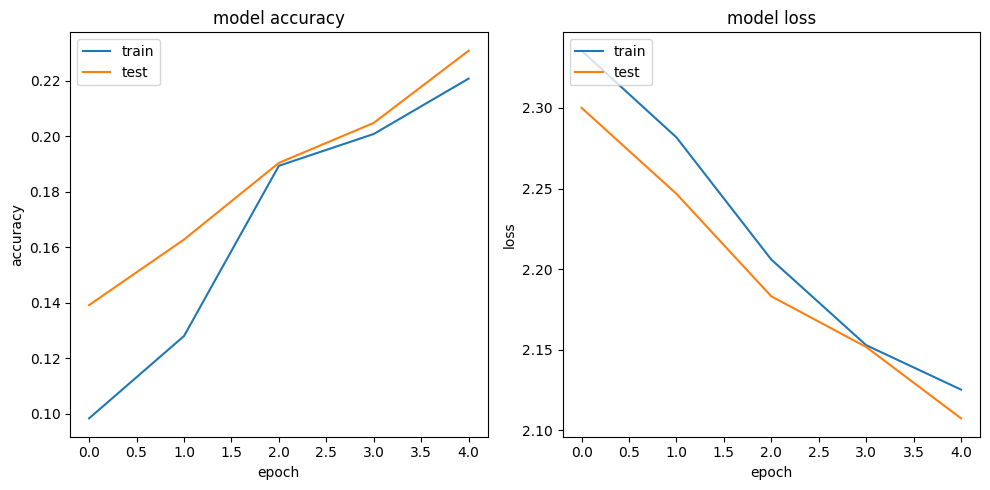

In [ ]:
def plot_history(history):
    # summarize history for accuracy
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.tight_layout()
    plt.show()

plot_history(history_10cl)

### Predictions


In [ ]:
# Download
# -q is for "quiet"
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg


1/1 [==============================] - 0s 67ms/step
Multiclass


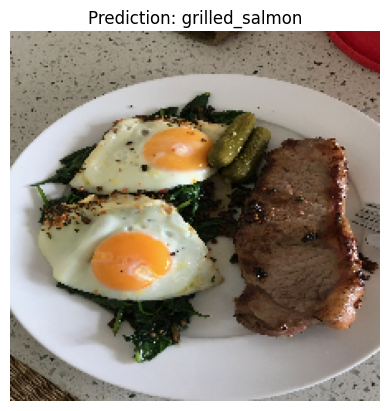

In [ ]:
filename = "03-steak.jpeg"
#filename = "03-pizza-dad.jpeg"
#filename = "03-hamburger.jpeg"
#filename = "03-sushi.jpeg"
img_prepared = load_and_prep_image(filename, img_shape=224)
pred_and_plot(model_10cl, filename, class_names)

## saving and loading model

In [ ]:
# save a model
model_10cl.save("saved_trained_model_10")

In [ ]:
# load in a trained modela and evaluate it
loaded_model_10cl = tf.keras.models.load_model("saved_trained_model_10")
loaded_model_10cl.evaluate(test_data)

79/79 [==============================] - 10s 125ms/step - loss: 2.1074 - accuracy: 0.2308


[2.1073620319366455, 0.23080000281333923]

In [ ]:
# compare our loaded model to our existing model
model_10cl.evaluate(test_data)

79/79 [==============================] - 7s 88ms/step - loss: 2.1074 - accuracy: 0.2308


[2.1073615550994873, 0.23080000281333923]